In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [6]:
'''DATADIR = 'image_train'

IMAGE_SIZE = 224
BATCH_SIZE = 64

traindatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input,
    validation_split=0.2)

train_generator = traindatagen.flow_from_directory(
    DATADIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = traindatagen.flow_from_directory(
    DATADIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')'''

Found 51367 images belonging to 107 classes.
Found 12813 images belonging to 107 classes.


In [9]:
train_path = 'vegetables'
valid_path = 'vegetables_val'
test_path = 'vegetables_test'

IMAGE_SIZE = 224
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #rotation_range=30,
    preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    train_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    valid_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    test_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE, shuffle=False)

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

Found 39595 images belonging to 84 classes.
Found 8130 images belonging to 84 classes.
Found 756 images belonging to 84 classes.


((64, 224, 224, 3), (64, 84))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'baby_back_ribs': 0, 'bagel_beigel': 1, 'baklava': 2, 'banana': 3, 'beef_carpaccio': 4, 'beef_tartare': 5, 'beignets': 6, 'bell_pepper': 7, 'bibimbap': 8, 'broccoli': 9, 'cabbage': 10, 'carrot': 11, 'carrot_cake': 12, 'celery': 13, 'cheese_plate': 14, 'cheeseburger': 15, 'chicken_curry': 16, 'chicken_quesadilla': 17, 'chicken_wings': 18, 'chinese_cabbage': 19, 'churros': 20, 'clam_chowder': 21, 'club_sandwich': 22, 'corn': 23, 'crab_cakes': 24, 'creme_brulee': 25, 'croque_madame': 26, 'cucumber': 27, 'cup_cakes': 28, 'deviled_eggs': 29, 'donuts': 30, 'dumplings': 31, 'edamame': 32, 'eggplant': 33, 'filet_mignon': 34, 'fish_and_chips': 35, 'french_fries': 36, 'french_onion_soup': 37, 'fried_rice': 38, 'garlic_bread': 39, 'granny_Smith': 40, 'guacamole': 41, 'gyoza': 42, 'hot_and_sour_soup': 43, 'hot_dog': 44, 'ice_cream': 45, 'lemon': 46, 'lobster_bisque': 47, 'macaroni_and_cheese': 48, 'macarons': 49, 'miso_soup': 50, 'mussels': 51, 'omelette': 52, 'onion': 53, 'onion_rings': 54, 'ora

In [11]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [12]:
base_model.trainable = False

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
model.add(layers.AveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(84, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5898752   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 84)                43092     
Total para

In [14]:
model.compile(optimizer=optimizers.Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5898752   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 84)                43092     
Total para

In [15]:
epochs = 5

history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)


Epoch 1/5
619/619 [==============================] - 413s 667ms/step - loss: 3.1770 - acc: 0.2769 - val_loss: 1.4602 - val_acc: 0.6123
Epoch 2/5
619/619 [==============================] - 422s 682ms/step - loss: 1.7588 - acc: 0.5489 - val_loss: 1.1758 - val_acc: 0.6831
Epoch 3/5
619/619 [==============================] - 422s 682ms/step - loss: 1.3752 - acc: 0.6343 - val_loss: 1.0953 - val_acc: 0.7062
Epoch 4/5
619/619 [==============================] - 418s 676ms/step - loss: 1.1506 - acc: 0.6852 - val_loss: 1.0722 - val_acc: 0.7098
Epoch 5/5
619/619 [==============================] - 412s 665ms/step - loss: 0.9895 - acc: 0.7245 - val_loss: 1.0648 - val_acc: 0.7134


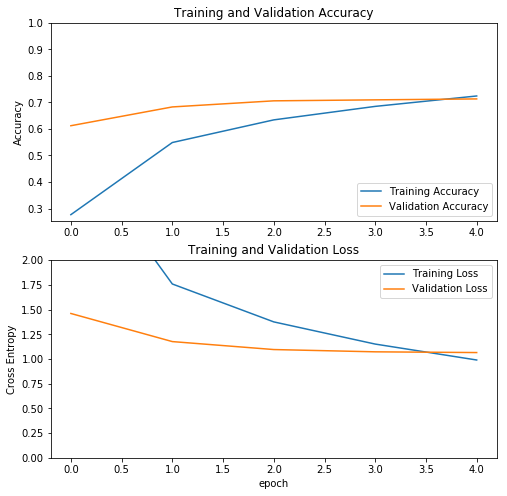

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(0.0001),
              metrics=['accuracy'])
filepath="mobilenetV2_model_best.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.summary()
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5898752   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 84)                43092     
Total para

In [20]:
history_fine = model.fit(train_generator, 
                         epochs=20,
                         validation_data=val_generator,
                         callbacks=[checkpoint])

Epoch 1/20
128/128 [==============================] - 74s 576ms/step - loss: 1.0532 - acc: 0.7262

Epoch 00001: val_acc improved from -inf to 0.72620, saving model to mobilenetV2_model_best.h5
619/619 [==============================] - 414s 669ms/step - loss: 0.8213 - acc: 0.7670 - val_loss: 1.0532 - val_acc: 0.7262
Epoch 2/20
128/128 [==============================] - 73s 574ms/step - loss: 1.0732 - acc: 0.7394

Epoch 00002: val_acc improved from 0.72620 to 0.73936, saving model to mobilenetV2_model_best.h5
619/619 [==============================] - 413s 667ms/step - loss: 0.5449 - acc: 0.8375 - val_loss: 1.0732 - val_acc: 0.7394
Epoch 3/20
128/128 [==============================] - 75s 586ms/step - loss: 0.9829 - acc: 0.7643

Epoch 00003: val_acc improved from 0.73936 to 0.76433, saving model to mobilenetV2_model_best.h5
619/619 [==============================] - 409s 660ms/step - loss: 0.3734 - acc: 0.8854 - val_loss: 0.9829 - val_acc: 0.7643
Epoch 4/20
128/128 [====================

In [21]:
keras_file = "food_mobilenetV2_model.h5"
tf.keras.models.save_model(model, keras_file)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('vegetables_test/carrot_cake/1381243.jpg',target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
x = keras.applications.mobilenet.preprocess_input(x)
prediction = model.predict(x)
maximum = max(prediction[0])
[i for i, j in enumerate(prediction[0]) if j == maximum]
#print(prediction)

[12]

In [22]:
#the fuction to draw a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps = 6,verbose=0)

In [24]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_batches.class_indices

{'baby_back_ribs': 0,
 'bagel_beigel': 1,
 'baklava': 2,
 'banana': 3,
 'beef_carpaccio': 4,
 'beef_tartare': 5,
 'beignets': 6,
 'bell_pepper': 7,
 'bibimbap': 8,
 'broccoli': 9,
 'cabbage': 10,
 'carrot': 11,
 'carrot_cake': 12,
 'celery': 13,
 'cheese_plate': 14,
 'cheeseburger': 15,
 'chicken_curry': 16,
 'chicken_quesadilla': 17,
 'chicken_wings': 18,
 'chinese_cabbage': 19,
 'churros': 20,
 'clam_chowder': 21,
 'club_sandwich': 22,
 'corn': 23,
 'crab_cakes': 24,
 'creme_brulee': 25,
 'croque_madame': 26,
 'cucumber': 27,
 'cup_cakes': 28,
 'deviled_eggs': 29,
 'donuts': 30,
 'dumplings': 31,
 'edamame': 32,
 'eggplant': 33,
 'filet_mignon': 34,
 'fish_and_chips': 35,
 'french_fries': 36,
 'french_onion_soup': 37,
 'fried_rice': 38,
 'garlic_bread': 39,
 'granny_Smith': 40,
 'guacamole': 41,
 'gyoza': 42,
 'hot_and_sour_soup': 43,
 'hot_dog': 44,
 'ice_cream': 45,
 'lemon': 46,
 'lobster_bisque': 47,
 'macaroni_and_cheese': 48,
 'macarons': 49,
 'miso_soup': 50,
 'mussels': 51,
 

Confusion matrix, without normalization
[[7 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 9 0 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 0 6]]


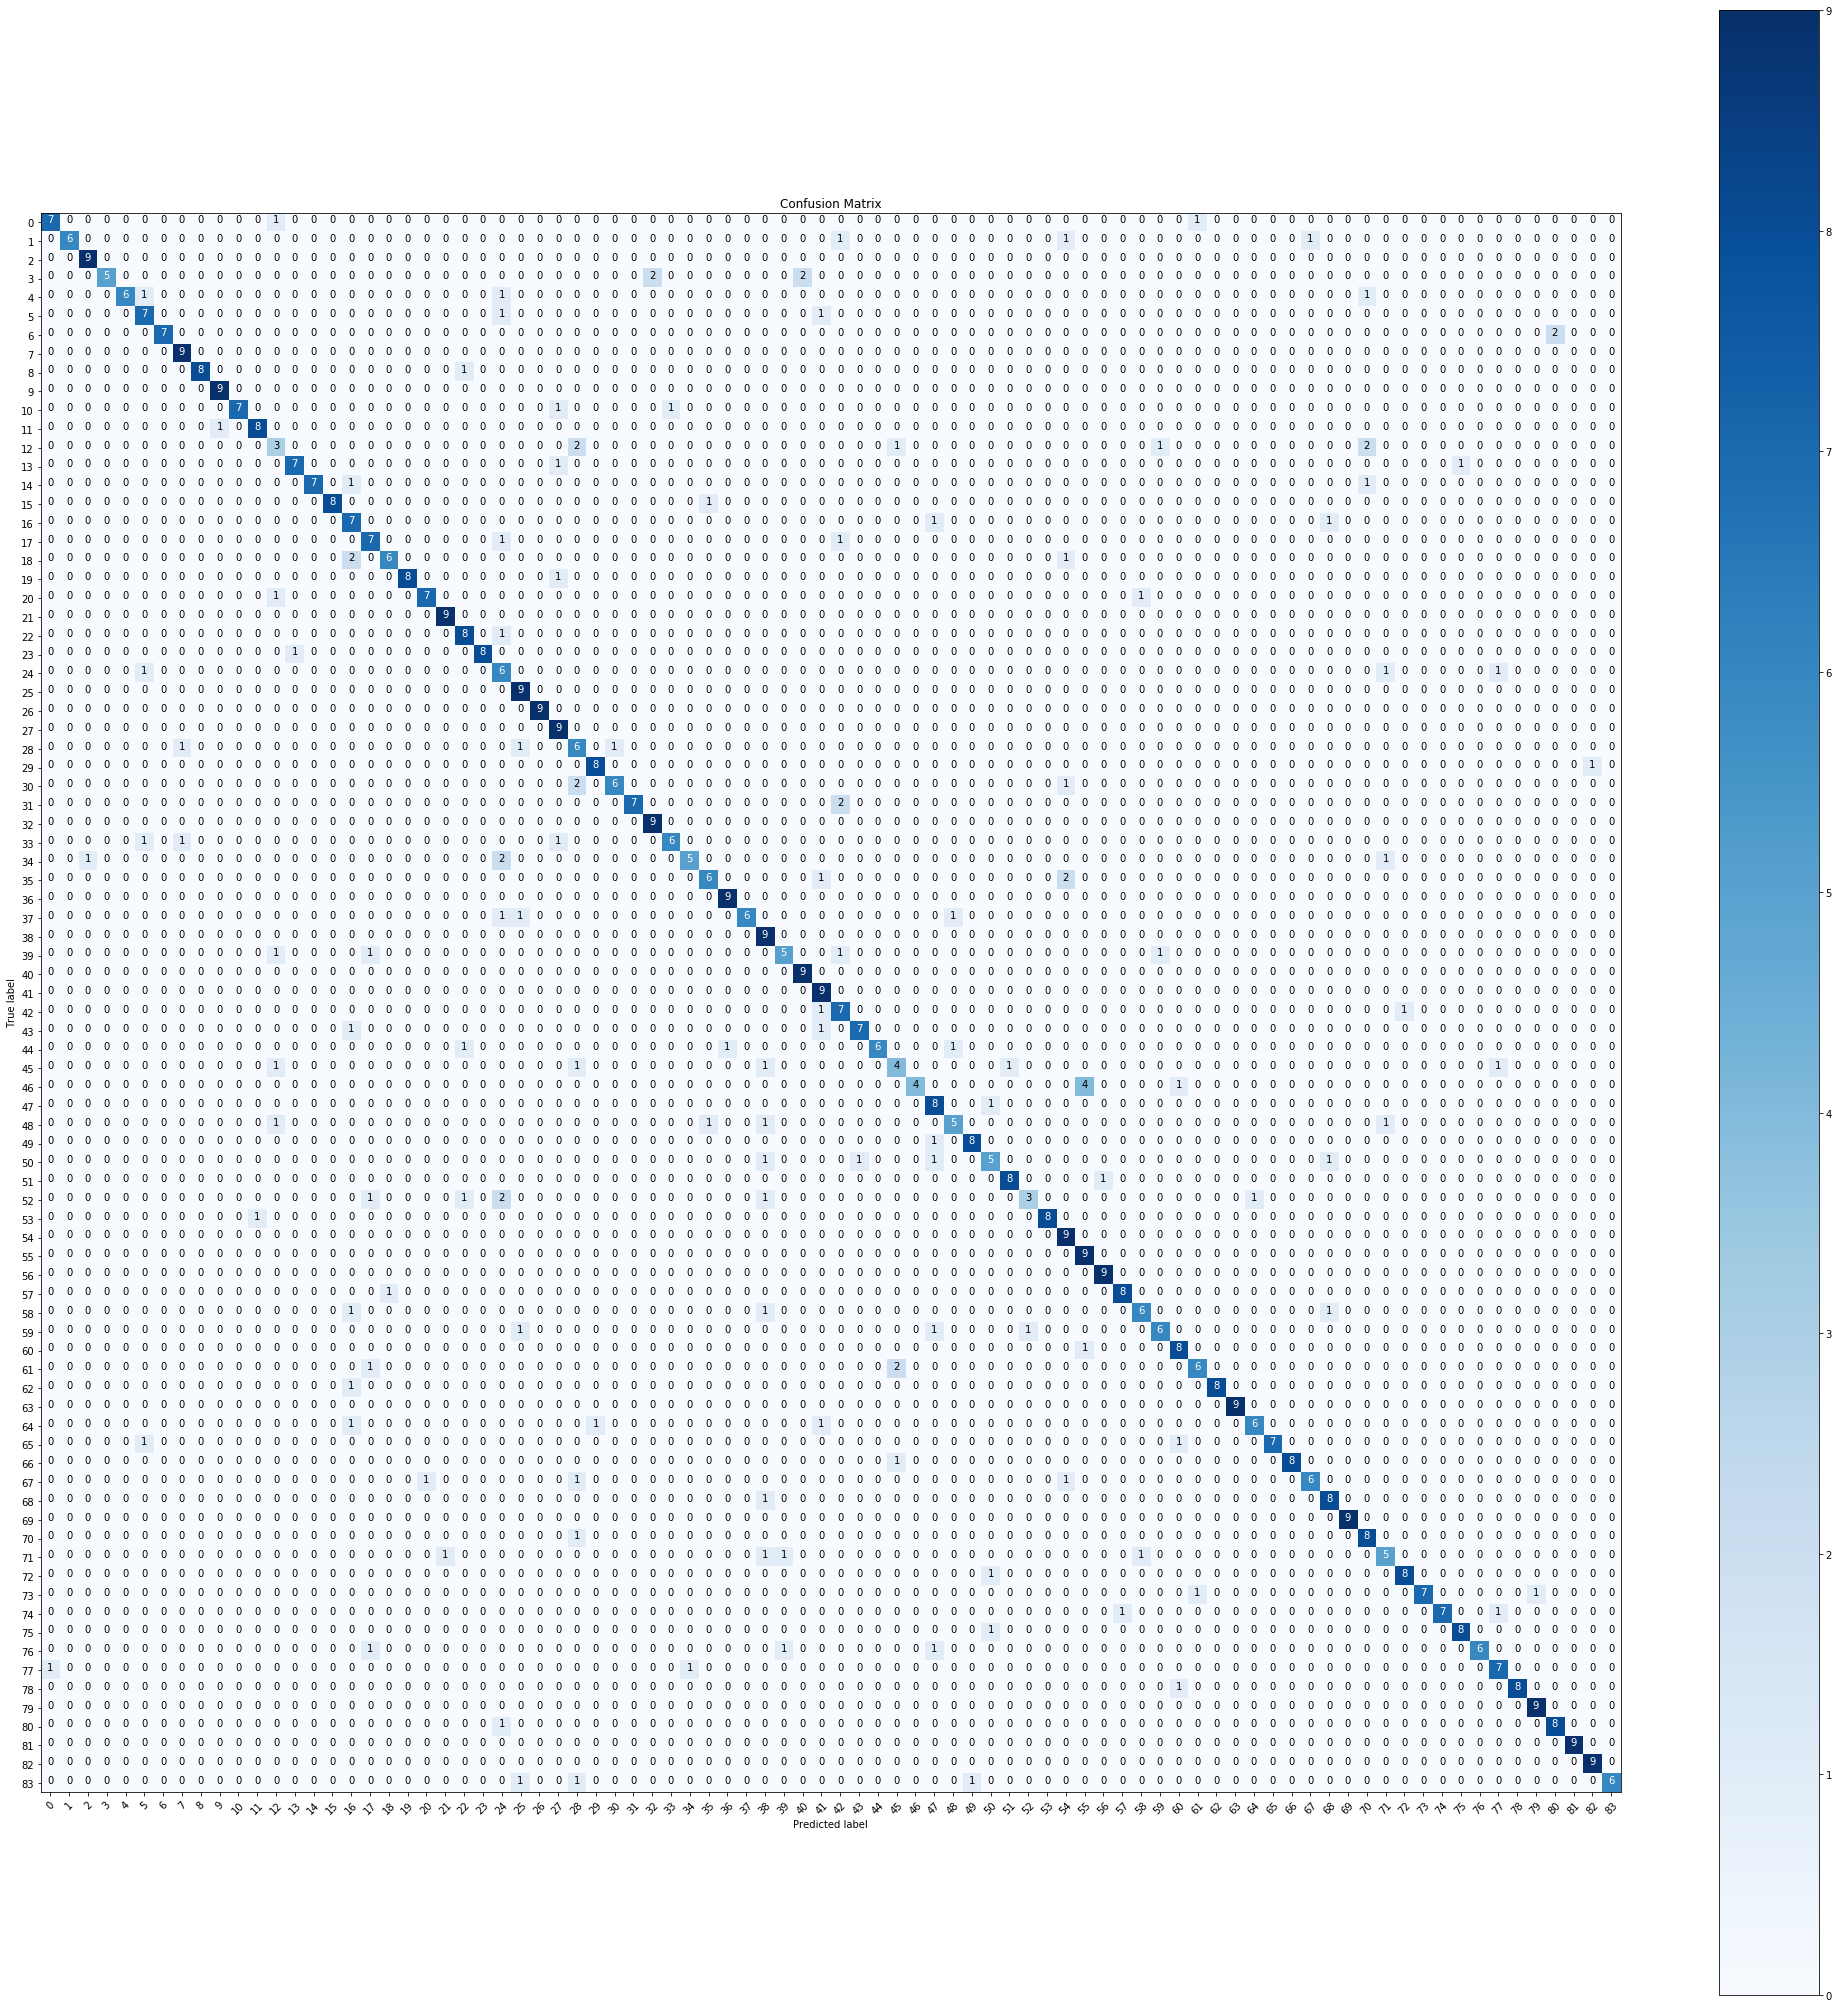

In [26]:
cm_plot_labels = [i for i in range(84)]
plt.figure()
fig = plt.gcf()
fig.set_size_inches(28, 28)
#cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')